## Simulation setups
Covariates are sampled uniformly from $[-B,B]^p$, where $p$ is feature size.

Parameters
+ **K**: 2 (number of arms)
+ **p**: 3 (feature size, the last two coordinates are noise)
+ **assignment probability floor**: $t^{-\alpha}/K$ with $\alpha=0.5$.
+ **scores**: AIPW
+ **noise distribution**: $\mathcal{N}(0,1)$
+ **agent**: Thompson sampling
+ **T**: $20000$ (Sample size)
+ **batch-size**: $100$
+ **explore_T**: $50*K$, the first batch size to do pure exploration.

Compared weighting:
- $h_t=1$;
- $h_t=t^{-\alpha/2}$;
- $h_t=t^{-\alpha}$;
- $h_t=t^{-2\alpha}$;
- data-collection agent.


Evaluation metric: out-of-sample regret using $100,000$ separate samples drawn from $(X, Y(1), \dots, Y(K))$.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


In [3]:
from glob import glob
def read_files(file_name):
    files = glob(file_name)
    results = []
    for file in files:
        r = np.load(file)
        results.extend(r)
    return np.array(results)

In [4]:
results = read_files('results/synthetic-v2_lfo/synthetic-v2_lfo_*.npy')

In [5]:
results.shape

(9980, 21)

In [6]:
def get_df(results):
    l = len(results)
    df = pd.DataFrame()
    method = ['uniform',  'uniform_ipw', 
              r'$t^{-\alpha/2}$', r'$t^{-\alpha/2}$_ipw', 
              r'$t^{-\alpha}$', r'$t^{-\alpha}$_ipw', 
               r'$t^{-1.2\alpha}$',  r'$t^{-1.2\alpha}$_ipw', 
              r'$t^{-1.3\alpha}$', r'$t^{-1.3\alpha}$_ipw',
              r'$t^{-1.5\alpha}$',  r'$t^{-1.5\alpha}$_ipw',
              r'$t^{-2\alpha}$',   r'$t^{-2\alpha}$_ipw',
              #r'$E[\max_w e_t^{-1}(X,w)]^{-1/2}$',
              'TS agent']
    for i, m in zip(range(6,6+len(method)), method):
        df = pd.concat([df, pd.DataFrame({'T': np.array(results[:,0], dtype=int), 
                                'B': np.array(results[:,1], dtype=float),
                                'signal': np.array(results[:,2], dtype=float),
                                'floor_decay': np.array(results[:,3], dtype=float),
                                'policy_class': results[:, 4],
                                'bias': results[:,5],
                               'regret': np.array(results[:,i], dtype=float),
                               'method': [m] * l})],  ignore_index=True)
    return df


In [7]:
df = get_df(results)

In [8]:
df

,T,B,signal,floor_decay,policy_class,bias,regret,method
0,2000,0.5,1.0,0.5,tree,True,0.015264,uniform
1,4000,0.5,1.0,0.5,tree,True,0.019833,uniform
2,6000,0.5,1.0,0.5,tree,True,0.042232,uniform
3,8000,0.5,1.0,0.5,tree,True,0.033749,uniform
4,10000,0.5,1.0,0.5,tree,True,0.033705,uniform
...,...,...,...,...,...,...,...,...
149695,12000,0.5,1.0,0.5,tree,True,0.669992,TS agent
149696,14000,0.5,1.0,0.5,tree,True,0.669193,TS agent
149697,16000,0.5,1.0,0.5,tree,True,0.664958,TS agent
149698,18000,0.5,1.0,0.5,tree,True,0.667155,TS agent


In [9]:
def plot_log_regret(ax):
    hue_order = ['uniform', r'$t^{-\alpha/2}$',  r'$t^{-\alpha}$', 
                                 r'$t^{-1.3\alpha}$',
                                #r'$t^{-1.4\alpha}$',
                                #r'$t^{-1.5\alpha}$',
                             #   r'$t^{-1.8\alpha}$',
                             r'$t^{-2\alpha}$', 
                             'TS agent',
                            ]
    g = sns.lineplot(x='T', y='regret', hue='method', 
                     hue_order=hue_order,
                     data=df.query(f"method in {hue_order}"),
                     ax=ax,
                    )

    ax.set_xlabel('Sample Size', fontsize=15)
    ax.set_ylabel('')
    ax.set_title('Log Regret', fontsize=15)
    ax.set_yscale('log')
    handles, labels = ax.get_legend_handles_labels()
    labels_modifier = [r'$h_t=1$', r'$h_t=t^{-0.5\alpha}$', r'$h^*_t=t^{-\alpha}$', 
                       r'$h_t=t^{-1.3\alpha}$',# r'$h_t=t^{-(\alpha+1)/2}$', 
                       r'$h_t=t^{-2\alpha}$', 
                       'TS agent' 
                      ]
    ax.legend( handles=handles, labels=labels_modifier, ncol=1,fontsize=12)
    #print(ax.get_legend_handles_labels())

    #plt.savefig('synthetic.pdf',bbox_inches='tight')

In [10]:

def plot_outcome_model(ax, bias=0):
    xs = np.linspace(-2, 2, 1000)
    id_1 = xs < -1
    id_2 = (xs > -1) & (xs < 1)
    id_3 = xs > 1

    ax.plot(xs, xs ** 2 - 1 + bias, label=r'arm 1: $\mu_1(x)=x_1^2$')
    ax.plot(xs, 1 - xs ** 2 + bias, label=r'arm 2: $\mu_2(x)=2 -x_1^2$')
    ax.set_title('Outcome Model', fontsize=15)
    ax.set_xlabel(r'$x_1$', fontsize=15)
    ax.legend(fontsize=15)
    #plt.savefig('synthetic_data.pdf',bbox_inches='tight')

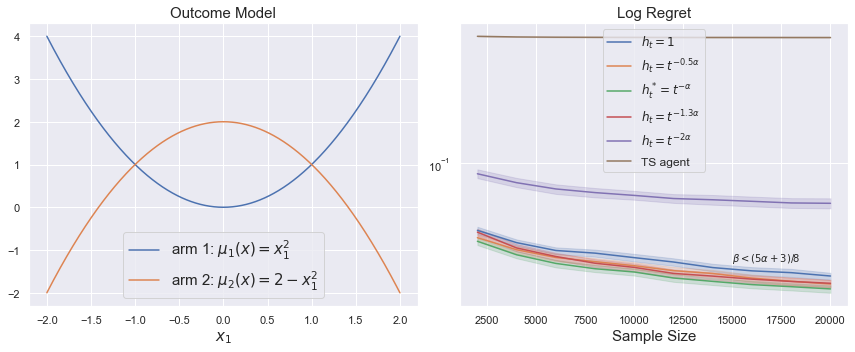

In [11]:
sns.set()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
plot_outcome_model(ax[0], bias=1)
plot_log_regret(ax[1])
ax[1].text(15000,0.023, r"$\beta<(5\alpha+3)/8$")
plt.tight_layout()
plt.savefig('synthetic_v2.pdf', bbox_inches="tight")